In [1]:
import numpy as np
import pandas as pd
from qiskit.circuit import QuantumCircuit


In [2]:
# definimos la función para realizar la integral del seno^2 
def sin_integral(upper_lim: float) -> float:
    #res_continuo = (upper_lim / 2.0 - np.sin(2 * upper_lim) / 4.0)
    res_continuo = (upper_lim / 2.0 - np.sin(2 * upper_lim) / 4.0 ) / upper_lim
    
    return res_continuo

#definimos la función para realizar la suma discretizada del seno^2.
def sin_discrete_sum(upper_lim: float, bits_number: int) -> float:
    n_dis = 2**bits_number
    res_discreto = 0.0
    
    for ii in range(n_dis):
        res_discreto += np.sin(upper_lim / n_dis * (ii + (1/2)))**2
        
    res_discreto = res_discreto / n_dis
    return res_discreto

b_max = np.pi / 4
n_bits = 2 #q-bits

mundo_continuo = sin_integral(b_max)
print("El resultado en el mundo continuo es: " + str(mundo_continuo))


mundo_discreto = sin_discrete_sum(b_max, n_bits)
print("El resultado en el mundo discreto es: " + str(mundo_discreto))

El resultado en el mundo continuo es: 0.1816901138162093
El resultado en el mundo discreto es: 0.1796355690323117


In [3]:
class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k


In [4]:
A = BernoulliA(mundo_discreto)
Q = BernoulliQ(mundo_discreto)

In [5]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [6]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_ibm_provider import IBMProvider
from qiskit import IBMQ #necesaria para llamar a la plataforma IBM Quantum
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit #necesaria para crear bits, qubits y circuitos
from qiskit import execute #necesaria para dar la orden de ejecución
from scipy.stats import beta



IBMProvider.save_account(token="d83e53dfa62683e4eb3ed49770c00c03322d6c921625a94e55cb84c76414b00d915b95732b9e00f1f7502809a7575326ab91316d0eac89acebfd88cc52e483aa", overwrite=True)

print("Realizar simulación en ordenador real o en simulador?")
#job_type = str(input())
job_type = "SIMULADOR"


while job_type.upper() not in {"REAL", "SIMULADOR"}:
    print("Por favor, introduce un parámetro válido -> real / simulador")
    job_type = str(input())


if job_type.upper() == "REAL":
    #en caso de querer realizar una ejecución en un ordenador cuántico tenemos dos posibilidades, EXTERNO o CSIC (cátedra UAM / IBM)
    acceso = "EXTERNO"
    Backend_qubits = 20
    print("Acceso seleccionado: "+acceso)
else:
    None


if job_type.upper() == "SIMULADOR":
    provider = IBMProvider()
    backend = provider.get_backend("ibmq_qasm_simulator")
    print("Simulador configurado correctamente: "+str(backend))
else:
    if acceso == 'CSIC' :
        # number of qubits to represent the uncertainty ***********************************************************************************************************
        numero_de_qbits_de_incertidumbre = 3
        #**********************************************************************************************************************************************************
        provider = IBMProvider(hub='ibm-q-csic')
        provider.backends()
        from qiskit.providers.ibmq import least_busy
        backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= Backend_qubits and
        not b.configuration().simulator and b.status().operational==True))
        print (backend)
        sistema_cuantico = str(backend)
        print("El programa se ejecutará en: "+str(sistema_cuantico))
        print (sistema_cuantico)
    
    else :
        # number of qubits to represent the uncertainty ***********************************************************************************************************
        numero_de_qbits_de_incertidumbre = 3
        #**********************************************************************************************************************************************************
        # Loading your IBM Quantum account(s)
        provider = IBMProvider()
        sistema_cuantico = 'ibmq_manila'
        backend = provider.get_backend(sistema_cuantico)
        print("El programa se ejecutará en: "+str(sistema_cuantico))


#quantum_instance = QuantumInstance(backend)

Realizar simulación en ordenador real o en simulador?
Simulador configurado correctamente: <IBMBackend('ibmq_qasm_simulator')>


In [7]:
print("El resultado analítico es: ", mundo_discreto)

from qiskit.algorithms import IterativeAmplitudeEstimation
from qiskit.primitives import Sampler

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    quantum_instance=backend
)
iae_result = iae.estimate(problem)

print("Estimate: ", iae_result.estimation)
print("Powers of Q: ", iae_result.powers)
print("Q's: ", iae_result.ratios)


relative_error = np.abs(mundo_discreto - iae_result.estimation)/mundo_discreto

print("Absolute Error: ", np.abs(mundo_discreto - iae_result.estimation))
print("Relative Error: ", relative_error)


El resultado analítico es:  0.1796355690323117


/tmp/ipykernel_122/908481594.py:6: DeprecationWarning: ``qiskit.algorithms.amplitude_estimators.iae.IterativeAmplitudeEstimation.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  iae = IterativeAmplitudeEstimation(


Estimate:  0.17952991384612602
Powers of Q:  [0, 0, 13]
Q's:  [1.0, 27.0]
Absolute Error:  0.00010565518618568803
Relative Error:  0.0005881640632467585


In [8]:
def P(qc, qx):
    """
        Generación de ua distribución de probablidad uniforme
            qc: quantum circuit
            qx: quantum register
            nbit: number of qubits
        The inverse of P = P
    """
    qc.h(qx)

def A(qc, qx, qx_measure, nbit, b_max):
    """
        Preparación del estado, integral de f()
            qc: quantum circuit
            qx: quantum register
            qx:measure: quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral            
    """
    qc.ry(b_max / 2**nbit * 2 * 0.5, qx_measure[0])
    
    for i in range(nbit):
        qc.cry(2**i * b_max / 2**nbit * 2, qx[nbit-1-i], qx_measure[0])
               
        
def Ainv(qc, qx, qx_measure, nbit, b_max):
    """
        Puerta inversa de A
            qc: quantum circuit
            qx: quantum register
            qx_measure : quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral
    """
    for i in range(nbit)[::-1]:
        qc.cry(-2**i * b_max / 2**nbit * 2, qx[nbit-1-i], qx_measure[0])
     
    qc.ry(-b_max / 2**nbit * 2 * 0.5, qx_measure[0])

def multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit):    
    """
        Creación de la puerta cuántica multi control NOT. 
            qc: circuito cuántico
            qx: registro
            qx_measure: registro sobre el que realizaremos la medida
            qx_ancilla: bit ancilla de control. 
            nbit: number of qubits
    """

    if nbit == 1:
        qc.cz(qx[0], qx_measure[0])
        
    elif nbit == 2:
        qc.h(qx_measure[0])
        qc.ccx(qx[0], qx[1], qx_measure[0])
        qc.h(qx_measure[0])
        
    elif nbit > 2.0:
        qc.ccx(qx[0], qx[1], qx_ancilla[0])
        
        for i in range(nbit - 3):
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
            
        qc.h(qx_measure[0])
        qc.ccx(qx[nbit - 1], qx_ancilla[nbit - 3], qx_measure[0])
        qc.h(qx_measure[0])
        
        for i in range(nbit - 3)[::-1]:
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
            
        qc.ccx(qx[0], qx[1], qx_ancilla[0])


#def reflect(qc, qx, qx_measure, qx_ancilla, nbit, b_max):        
def S_0(qc, qx, qx_measure, qx_ancilla, nbit):
    """
        Operador de reflexion (I - 2|0><0|). Hacemos la reflexión sobre el eje del vector complejo
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    qc.barrier()
    for i in range(nbit):
        qc.x(qx[i])
    
    qc.x(qx_measure[0])
    #multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
    multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit)
    qc.x(qx_measure[0])
    
    for i in range(nbit):
        qc.x(qx[i])
    
    qc.barrier()

# This is to implement Grover Operator Q
def Q(qc, qx, qx_measure, qx_ancilla, nbit, b_max):
    """
        El operador de Grover
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    qc.z(qx_measure[0])
    qc.barrier()
    
    Ainv(qc, qx, qx_measure, nbit, b_max)
    qc.barrier()
    P(qc, qx)

    S_0(qc, qx, qx_measure, qx_ancilla, nbit)
    P(qc, qx)
    qc.barrier()
    A(qc, qx, qx_measure, nbit, b_max)    

In [9]:
def create_grover_circuit(number_grover, nbit, b_max):
    """
        To generate quantum circuits running Grover operators with number of iterations in number_grover
            numebr_grover: number of Grover operators
            nbit: number of qubits (2**nbit = ndiv is the number of discretization in the Monte Carlo integration)
            b_max: upper limit of integral
        Return:
            qc: quantum circuit with Grover operators as in number_grover
    """
        
    qx = QuantumRegister(nbit)
    qx_measure = QuantumRegister(1)
    cr = ClassicalRegister(1)
    if (nbit > 2):
        qx_ancilla = QuantumRegister(nbit - 2)
        qc = QuantumCircuit(qx, qx_ancilla, qx_measure, cr)
    else:
        qx_ancilla = 0
        qc = QuantumCircuit(qx, qx_measure, cr)

    P(qc, qx)
    qc.barrier()
    A(qc, qx, qx_measure, nbit, b_max)
    qc.barrier()

    for ii in range(number_grover):
        Q(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
    
    qc.measure(qx_measure[0], cr[0])
    
    return qc

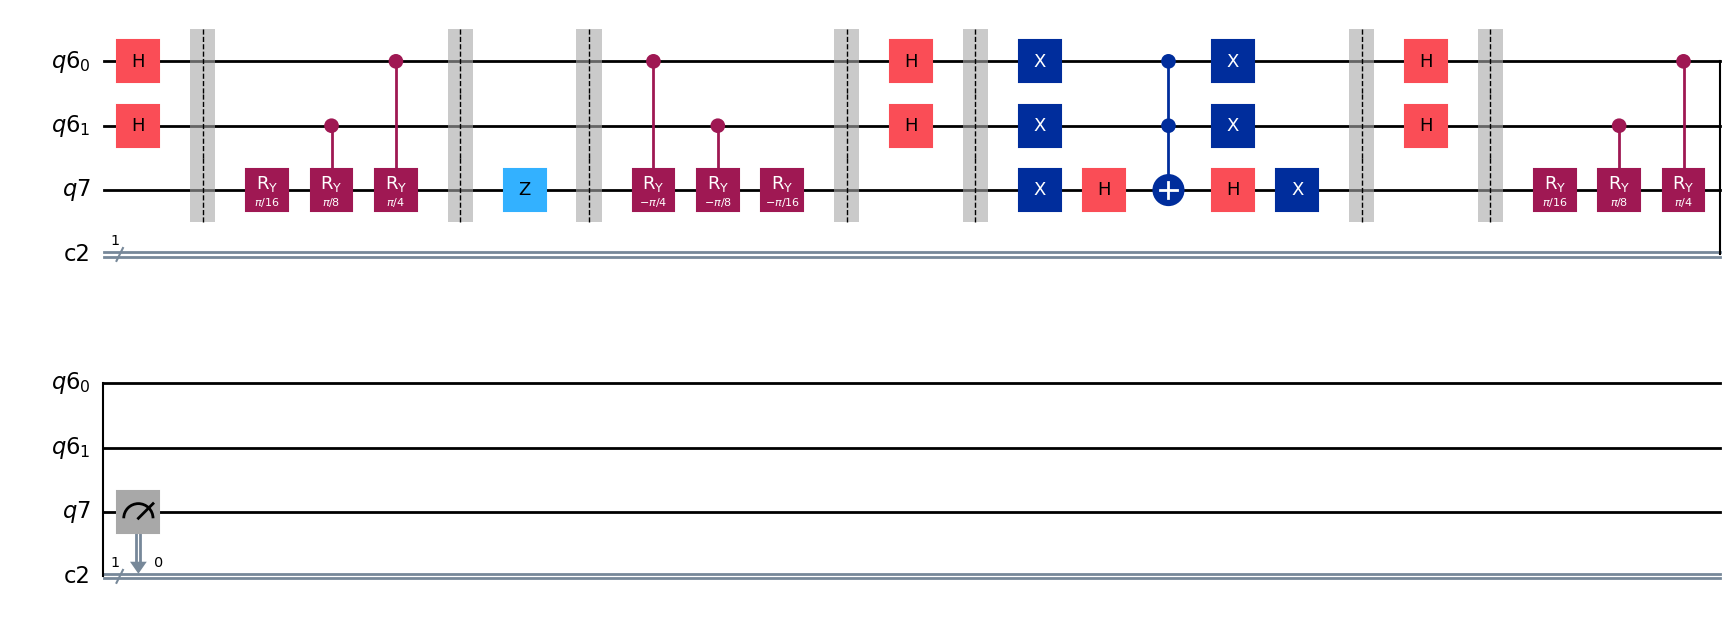

In [10]:
qc = create_grover_circuit(1, n_bits, b_max)
qc.draw("mpl", style="iqx")

In [11]:
def run_grover(qc, number_grover, shots, backend):
    """
        Run the quantum circuits returned by create_grover_circuit()
            qc_list: list of quantum circuits
            numebr_grover_list
            shots_list:  list of number of shots
            backend: name of backends
        
        Return:
            hit_list: list of count of obserbving "1" for qc_list
    """
    
    job = execute(qc, backend=backend, shots=shots)

    counts = job.result().get_counts(qc).get("1", 0)
    print("Number of 1's hit: "+str(counts))

    p_k = counts/shots
        
    return counts

In [12]:
def clopper_pearson(count, n, alpha):
    """Calculates the confidence interval for the quantity to estimate `a`.

    Args:
        count (int): number of successes.
        n (int): total number of trials.
        alpha (float): significance level. Must be in (0, 0.5).

    Return:
        The confidence interval [a_min, a_max].
    """
    beta_prob_function = scipy.stats.beta.ppf
    a_min = beta_prob_function(alpha / 2, count, n - count + 1)
    a_max = beta_prob_function(1 - alpha / 2, count + 1, n - count)
    if np.isnan(a_min):
        a_min = 0
    if np.isnan(a_max):
        a_max = 1
    return a_min, a_max

def h_calc_CP(n_successes, n_total_shots, upper_bound_t):
    """Calculates the `h` function.

    Args:
        n_successes (int): number of successes.
        n_total_shots (int): total number of trials.
        upper_bound_t (int): maximum number of rounds to achieve the desired absolute error.

    Returns:
        The h function for the given inputs.
    """
    a_min, a_max = clopper_pearson(
        n_successes, n_total_shots, alpha=(alpha / upper_bound_t)
    )
    return np.abs(np.arccos(1 - 2 * a_max) - np.arccos(1 - 2 * a_min)) / 2
    


def calc_L_range_CH(n_shots, upper_bound_t):
    """Calculate the confidence interval for the Chernoff method.

    Args:
        n_shots (int): number of shots.
        upper_bound_t (int): maximum number of rounds to achieve the desired absolute error.

    Returns:
        max_L, min_L (float, float): The maximum and minimum possible error which could be returned
        on a given iteration.
    """
    max_L = (
        np.arcsin(
            (2 / (n_shots) * np.log(2 * upper_bound_t / alpha)) ** (1 / 4)
        )
        / 2
        / np.pi
    )
    min_L = np.arcsin(np.sin(max_L) ** 2)
    return max_L, min_L
    
def calc_L_range_CP(n_shots, upper_bound_t):
    """Calculate the confidence interval for the Clopper-Pearson method.

    Args:
        n_shots (int): number of shots.
        upper_bound_t (int): maximum number of rounds to achieve the desired absolute error.

    Returns:
        max_L, min_L (float, float): The maximum and minimum possible error which could be returned
        on a given iteration.
    """
    x = np.linspace(0, np.pi, 10000)
    x_domain = [x <= 1.0 + 1 / 10 / n_shots]
    y = [
        h_calc_CP(int(t * n_shots), n_shots, upper_bound_t)
        for t in x[tuple(x_domain)]
    ]
    max_L = np.max(y) / (2 * np.pi)
    min_L = np.min(y) / (2 * np.pi)
    return max_L, min_L


def find_next_k(k, upper_half_circle, theta_l, theta_u, min_ratio = 2.0):
    """Find the largest integer k_next, such that the interval (4 * k_next + 2)*theta_interval
    lies completely in [0, pi] or [pi, 2pi], for theta_interval = (theta_lower, theta_upper).

    Args:
        k: The current power of the Q operator.
        upper_half_circle: Boolean flag of whether theta_interval lies in the
            upper half-circle [0, pi] or in the lower one [pi, 2pi].
        theta_interval: The current confidence interval for the angle theta,
            i.e. (theta_lower, theta_upper).
        min_ratio: Minimal ratio K/K_next allowed in the algorithm.

    Returns:
        The next power k, and boolean flag for the extrapolated interval.

    """

    # the largest feasible scaling factor K cannot be larger than K_max,
    # which is bounded by the length of the current confidence interval
    max_scaling = int(1 / (2 * (theta_u - theta_l)))
    scaling = max_scaling - (max_scaling - 2) % 4  # bring into the form 4 * k_max + 2

    # find the largest feasible scaling factor K_next, and thus k_next
    while scaling >= min_ratio * k:
        theta_min = scaling * theta_l - int(scaling * theta_l)
        theta_max = scaling * theta_u - int(scaling * theta_u)

        if theta_min <= theta_max <= 0.5 and theta_min <= 0.5:
            # the extrapolated theta interval is in the upper half-circle
            upper_half_circle = True
            return int(scaling), upper_half_circle

        elif theta_max >= 0.5 and theta_max >= theta_min >= 0.5:
            # the extrapolated theta interval is in the upper half-circle
            upper_half_circle = False
            return int(scaling), upper_half_circle

        scaling -= 4

    # if we do not find a feasible k, return the old one
    return int(k), upper_half_circle
    
def iqae(shots, backend, epsilon, alpha, method_interval = "chernoff"):
    # Initializing all parameters
    k = [0]
    # uppercase_k=4k+2
    uppercase_k = [2]
    ratios = []

    theta_u = 1 / 4
    theta_l = 0
    theta_intervals = [theta_l, theta_u]
    a_intervals = [
        np.sin(2 * np.pi * theta_l) ** 2,
        np.sin(2 * np.pi * theta_u) ** 2,
    ]
    a_min = [0]
    a_max = [1]
    theta_dif = np.abs(theta_u - theta_l)
    up = [True]
    samples_history = []
    n_shots_history = []

    eps = epsilon / (2 * np.pi)
    upper_bound_t = int(np.log2(np.pi / (8 * epsilon))) + 1
    n_total_shots = shots
    num_oracle_queries = 0

    if method_interval == "chernoff":
        # Chernoff method
        max_L, min_L = calc_L_range_CH(n_total_shots, upper_bound_t)

    else:
        # Clopper-Pearson (beta) method
        max_L, min_L = calc_L_range_CP(n_total_shots, upper_bound_t)

    i = 0
    while theta_dif > 2 * eps:

        i = i + 1
        uppercase_k_i, up_i = find_next_k(uppercase_k[-1], up[-1], theta_l, theta_u)
        k_i = int((uppercase_k_i - 2) / 4)
        uppercase_k.append(uppercase_k_i)
        up.append(up_i)
        k.append(k_i)

        ratios.append(int(np.ceil((2 * k[-1] + 1) / (2 * k[-2] + 1))))

        # Checking the no-overshooting condition
        #if uppercase_k_i > int(max_L / eps):
        #    # We ensure to not make unnecessary measurement shots at last iterations of the algorithm
        #    n_shots_i = int((max_L / eps) * shots / uppercase_k_i / 10)
        #    # To avoid having a null number of shots
        #    if n_shots_i == 0:
        #        n_shots_i = 1
        #else:
        #    n_shots_i = shots
        n_shots_i = shots
        # Calling and executing the quantum circuit
        qc = create_grover_circuit(k_i, 2, np.pi/4)  # creamos el circuito
        samples = run_grover(qc, k_i, shots, backend)

        samples_history.append(samples)
        n_shots_history.append(n_shots_i)

        num_oracle_queries += n_shots_i * k_i

        m = 1
        if i > 1:
            while k[i - m] == k[i] and i >= m + 1:
                m += 1
            sum_total_samples = sum([samples_history[j] for j in range(i - m, i)])
            n_total_shots = sum([n_shots_history[j] for j in range(i - m, i)])

        else:
            sum_total_samples = samples
            n_total_shots = n_shots_i

        a = sum_total_samples / n_total_shots

        if method_interval == "chernoff":
            delta_a = np.sqrt(
                np.log(2 * upper_bound_t / alpha) / 2 / n_total_shots
            )
            a_min_i = max(0, a - delta_a)
            a_max_i = min(1, a + delta_a)
        else:
            a_min_i, a_max_i = clopper_pearson(
                sum_total_samples, n_total_shots, alpha=alpha / upper_bound_t
            )
        a_min.append(a_min_i)
        a_max.append(a_max_i)

        if up_i:
            theta_min_i = np.arccos(1 - 2 * a_min_i) / 2 / np.pi
            theta_max_i = np.arccos(1 - 2 * a_max_i) / 2 / np.pi
        else:
            theta_min_i = 1 - np.arccos(1 - 2 * a_max_i) / 2 / np.pi
            theta_max_i = 1 - np.arccos(1 - 2 * a_min_i) / 2 / np.pi

        theta = min(int(uppercase_k_i * theta_u), int(uppercase_k_i * theta_l))

        theta_u = (theta + theta_max_i) / uppercase_k_i
        theta_l = (theta + theta_min_i) / uppercase_k_i
        theta_dif = np.abs(theta_u - theta_l)
        theta_intervals.append([theta_l, theta_u])

        a_l = np.sin(2 * np.pi * theta_l) ** 2
        a_u = np.sin(2 * np.pi * theta_u) ** 2
        a_intervals.append([a_l, a_u])


    result = {
        "alpha":alpha,
        "epsilon_target":epsilon,
        "epsilon_estimated":(a_u - a_l) / 2,
        "estimate_intervals":a_intervals,
        "num_oracle_queries":num_oracle_queries,
        "estimation":(a_u + a_l) / 2,
        "theta_intervals":theta_intervals,
        "k":k,
        "ratios":ratios,
        "shots":n_shots_history,
        "iterations":i
    }

    return result

In [13]:
#shots_list = [32, 64, 128, 256, 512, 1024]  # lista de shots que haremos
shots = [32, 64, 128, 256, 512, 1024]# lista de shots que haremos
epsilon = 0.025 #target error
alpha = 1-epsilon #confidence level
final_result_df = pd.DataFrame()
n_grovers = []
a_candidate_list = []
rel_error_list = []
iterations = []
analytical_result = []


for shot in shots:
    print("SHOTS = "+str(shot))
    iqae_result = iqae(shot, backend, epsilon, alpha)
    print(iqae_result)
    a_candidate_list.append(iqae_result["estimation"])
    rel_error_list.append(np.abs(mundo_discreto - iqae_result["estimation"])/mundo_discreto)
    
    result_df = pd.DataFrame({"a_candidate":a_candidate_list, "rel_error":rel_error_list})
    
    result_df["n_grovers"] = iqae_result["k"][-1]
    result_df["n_shots"] = shot
    result_df["iterations"] = iqae_result["iterations"]
    result_df["analytical_result"] = mundo_discreto
    
    final_result_df = pd.concat([final_result_df, result_df], axis=0)
    a_candidate_list = []
    rel_error_list = []


SHOTS = 32
Number of 1's hit: 10
Number of 1's hit: 6
Number of 1's hit: 4
Number of 1's hit: 18
Number of 1's hit: 22
{'alpha': 0.975, 'epsilon_target': 0.025, 'epsilon_estimated': 0.008337758818959526, 'estimate_intervals': [0.0, 1.0, [0.1311526403872889, 0.49384735961271115], [0.12176805226757655, 0.3782319477324235], [0.10363238644410672, 0.31303428022256], [0.16648770247564215, 0.22585414520159275], [0.17596264200827208, 0.19263815964619113]], 'num_oracle_queries': 352, 'estimation': 0.1843004008272316, 'theta_intervals': [0, 0.25, [0.05897859790018217, 0.124020752155295], [0.056731324109006186, 0.10542314089755427], [0.05216407989381686, 0.09450238240427197], [0.0668918959862497, 0.07881958907384466], [0.06889361041579907, 0.07231688169238394]], 'k': [0, 0, 0, 0, 2, 9], 'ratios': [1, 1, 1, 5, 4], 'shots': [32, 32, 32, 32, 32], 'iterations': 5}
SHOTS = 64
Number of 1's hit: 16
Number of 1's hit: 6
Number of 1's hit: 12
Number of 1's hit: 47
Number of 1's hit: 55
{'alpha': 0.975, '

In [14]:
final_result_df

,a_candidate,rel_error,n_grovers,n_shots,iterations,analytical_result
0,0.184300,0.025968,9,32,5,0.179636
0,0.183601,0.022078,8,64,5,0.179636
0,0.177997,0.009124,4,128,3,0.179636
0,0.176382,0.018113,2,256,2,0.179636
0,0.178122,0.008425,4,512,2,0.179636
0,0.180057,0.002349,6,1024,2,0.179636


In [15]:
final_result_df.to_csv(r"../../Output/IQAE_vFin_results_SIM_QASM.csv")